In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from matplotlib.colors import LogNorm
from scipy.interpolate import RectBivariateSpline

import quasiclassical_solver as qs
from legendre import *

In [2]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456
u2au = 1822.88839

# Potential

7 47
0.2164


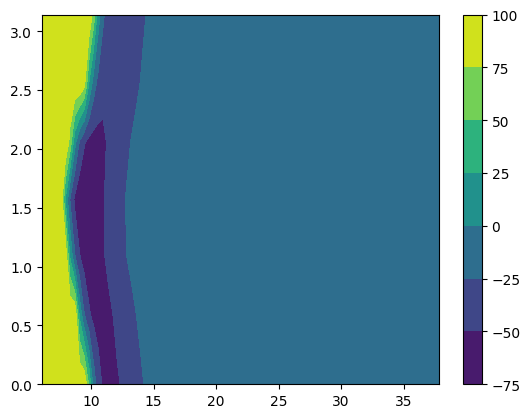

In [6]:
data = np.loadtxt( "../potentials/potential.dat" )


th_raw = np.array([0.0, 33.8783, 62.0404, 90.0, 117.96, 146.122, 180.0]) * np.pi / 180.

N_th = len(th_raw)
N_R = len( data ) // N_th

print( N_th, N_R )

R_raw = data[:N_R, 0]

PES_raw = np.reshape( data[:,1], (N_th, N_R) )


print( np.max( PES_raw ) )

PES_clip = np.clip(PES_raw * au2cm, -100, 100)
R_gr, th_gr = np.meshgrid( R_raw, th_raw )

plt.contourf( R_gr, th_gr, PES_clip )
plt.colorbar()

R_0 = 3.
R_f = 60.

N_barrier = 5
N_tail = 5

N_ext = N_R + N_tail + N_barrier

R_ext = np.zeros( N_ext )

R_ext[:N_barrier] = R_0 + ( R_raw[0] - R_0 ) * ( 1 + np.arange(N_barrier) ) / ( N_barrier + 1 )
R_ext[N_barrier:-N_tail] = R_raw
R_ext[-N_tail:] = R_raw[-1] + ( R_f - R_raw[-1] ) * ( 1 + np.arange(N_tail) ) / ( N_tail + 1 )


PES_ext = np.zeros( (N_th, N_ext) )

A = ( PES_raw[:, 1] - PES_raw[:, 0] ) / ( 1/R_raw[1]**12 - 1/R_raw[0]**12 )
B = PES_raw[:, 0] - A/R_raw[0]**12

A = np.reshape( A, (-1, 1) )
B = np.reshape( B, (-1, 1) )

PES_ext[:, :N_barrier] = A / np.reshape( R_ext[:N_barrier]**12, (1, -1) ) + B
PES_ext[:, N_barrier:-N_tail] = PES_raw

pass

j_init=0 finished
j_init=1 finished
j_init=2 finished
j_init=3 finished
j_init=4 finished
j_init=5 finished
j_init=6 finished
j_init=7 finished
j_init=8 finished
j_init=9 finished
j_init=10 finished


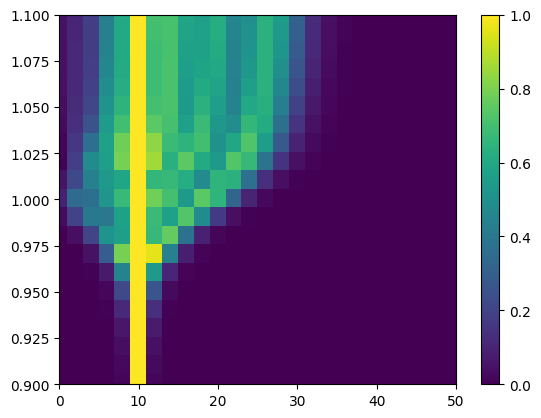

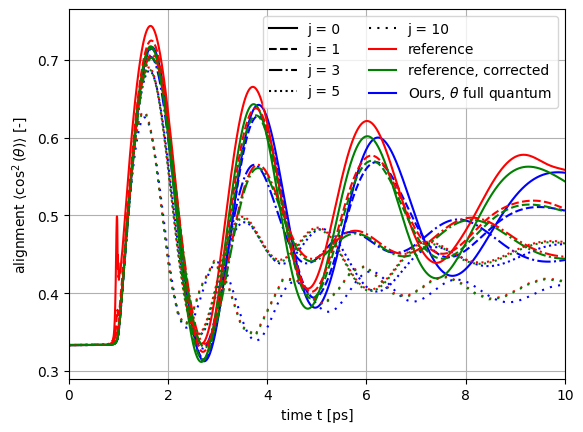

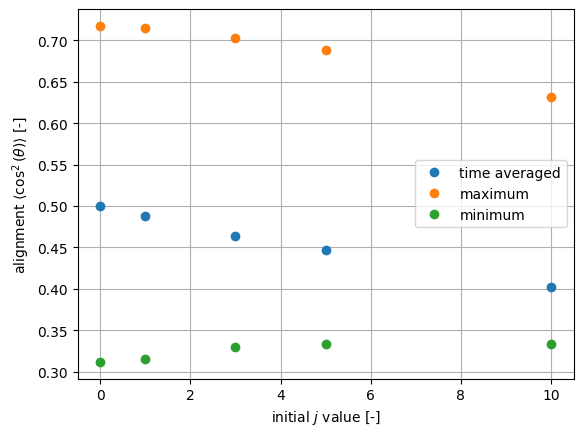

NameError: name 'l_arr' is not defined

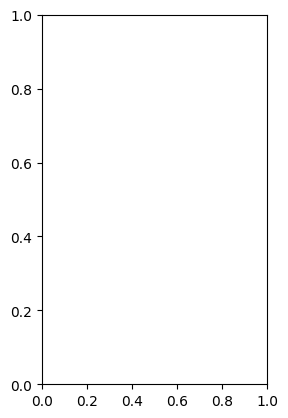

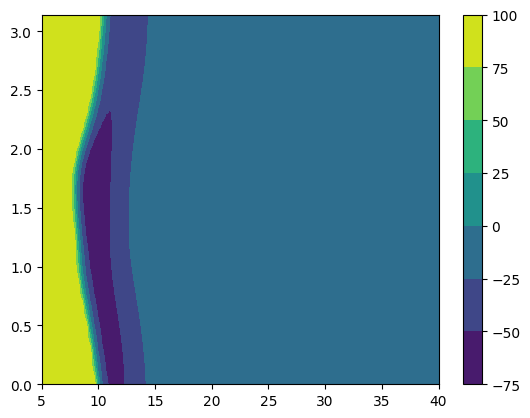

In [ ]:
V_interp = RectBivariateSpline( th_raw, np.flip( 1/R_ext ), np.flip( PES_ext, axis=1 ), kx=3, ky=3, s=0 )

def potential( r, th ):
    return V_interp( th, 1/r )

potential = np.vectorize( potential )

r_arr = np.linspace( 5, 40, 100 )
th_arr = np.linspace( 0, np.pi, 100 )


th_gr, r_gr = np.meshgrid( th_arr, r_arr )

PES_interp = potential( r_gr, th_gr )
PES_clip = np.clip(PES_interp * au2cm, -100, 100)

plt.contourf( r_gr, th_gr, PES_clip )
plt.colorbar()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# ax.plot_surface( r_gr, th_gr, PES_clip, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True )


# Simulation

In [4]:
solv = qs.Quasi_classic( m_rot = (16 + 32 + 12) * u2au, 
                        Be_rot = 9.243165268327e-7, 
                        m_proj = 20 * u2au 
                        )

solv.set_potential( potential )

j_init = 0
solv.set_hilbert_space( max_l=160, 
                       max_m = j_init
                       )

solv.set_initial_conditions( E_col = 3700 * 3.1668105e-6, 
                            r_0 = 50.0, 
                            l_0 = j_init 
                            )

solv.solve( t_max = 2 / au2ps,
           kwargs={"first_step": 1e3,
                   "max_step": 1e3,
                   "atol": 1e-9, "rtol": 1e-7}
           ) 

print( f"j_init={j_init} finished" )

pass

NameError: name 'potential' is not defined

# Plotting

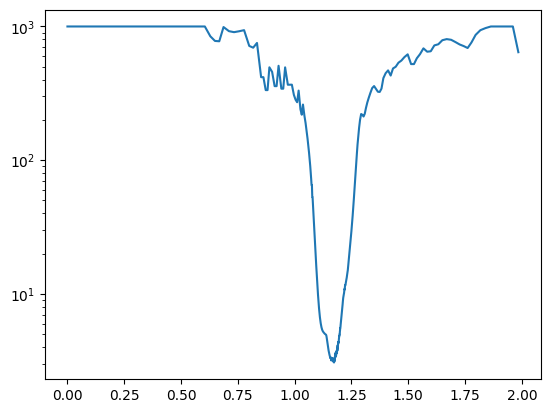

In [79]:
plt.plot( solv.t[:-1] * au2ps,  np.diff( solv.t ) )

plt.semilogy()

pass

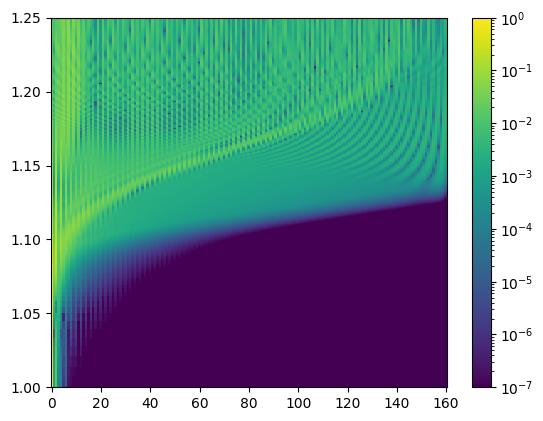

In [78]:
l_max = np.max( solv.l_arr )
rot_prob = np.zeros( (solv.N_t, l_max + 1) )

for i, l in enumerate( solv.l_arr ):
    rot_prob[:, l] += np.abs( solv.Psi[:, i] )**2

# rot_prob = rot_prob / np.reshape( np.max( rot_prob, axis=1 ), (-1,1) )

plt.pcolor(np.arange( l_max + 1 ), 
           solv.t*au2ps,
           rot_prob, norm=LogNorm(vmin = 1e-7) )

plt.colorbar()

# plt.xlim( -0.5, 50 )

plt.ylim( 1., 1.25 )

pass

0.9999994449379159


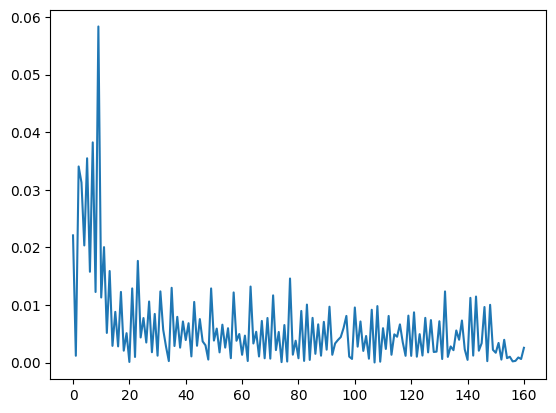

In [74]:
plt.plot( np.arange( l_max + 1 ), rot_prob[-1,:] )
# plt.semilogy()
print( np.sum( rot_prob[-1,:] ) )

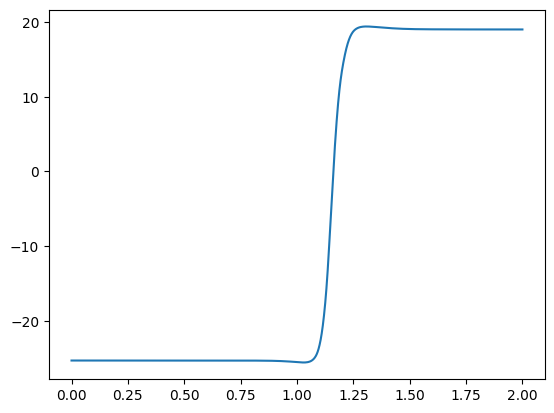

In [77]:
plt.plot( solv.t * au2ps, solv.p )
# plt.xlim( 0, 2 )
# plt.ylim( 0, 50 )